# Infinite Impulse Response (IIR) Delay Effect
### Author: Pawel Budzynski

In [1]:
from typing import Optional

import IPython
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft
import scipy.signal
import scipy.io.wavfile

In [2]:
sample_rate, sound = scipy.io.wavfile.read("string_1.wav")
IPython.display.Audio("string_1.wav")

IIR Delay effect will be implemented using the following formula:
$$s[t] = \alpha e[t] + \beta s[t-D], $$
where $e$ is the entry signal, $s$ is the output,
$\alpha ≥ 0$ is the scaling factor, $\beta ≥ 0$ the attenuation factor and and $D$ the time delay.

In [3]:
def iir_delay(
    signal: np.ndarray,
    alpha: float,
    beta: float,
    delay: float,
    sample_rate: int,
    output_size: Optional[int] = None,
) -> np.ndarray:
    """Apply FIR Delay effect for a given signal. 
        signal: the input signal.
        alpha: the scaling factor.
        beta: the attenuation factor.
        delay: time delay in seconds.
        sample_rate: the sample rate of the input signal.
        output_size: the size of the output signal, same as input signal by default.
    """
    # Determine the lenght of the output signal.
    if output_size is None:
        output_size = len(signal)
    output = np.zeros((output_size,))
    # Transform delay from time to amount of samples.
    D = int(delay * sample_rate)
    
    # Iteratively compute IIR Delay effect.
    for t in range(output_size):
        # Input signal and output delay defined.
        if 0 <= t-D and t < len(signal):
            output[t] = alpha * signal[t] + beta * output[t-D]
        # Delayed output undefined (equals zero).
        elif t < len(signal):
            output[t] = alpha * signal[t]
        # Input signal undefined (equals zero).
        else:
            output[t] = beta * output[t-D]
    return output

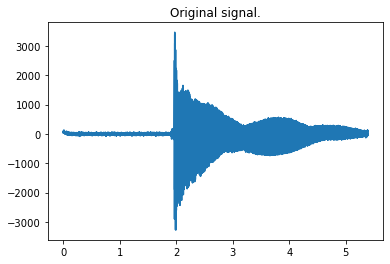

In [4]:
t_max = len(sound) / sample_rate
t = np.linspace(0, t_max, len(sound))
plt.plot(t, sound)
plt.title("Original signal.")
plt.show()

In [5]:
sound_delay = iir_delay(
    sound,
    alpha=1.5, 
    beta=0.5,
    delay=1,
    sample_rate=sample_rate,
    output_size=int(1.5*len(sound))
)

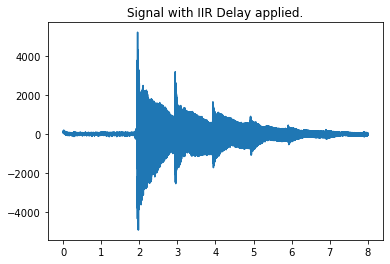

In [6]:
t_max = int(len(sound_delay) / sample_rate)
t = np.linspace(0, t_max, len(sound_delay))
plt.plot(t, sound_delay)
plt.title("Signal with IIR Delay applied.")
plt.show()

This kind of filter has a recursive formula thus it makes sense to generate the response with length greater than the length of the original signal. Depending of the choice of the parameters the output may look and behave in a very different way. Below a brief review of output signals for different set of parameters is presented.

In [7]:
# Helper function to plot signal with various parameters.
def plot_iir_output(alpha, beta, delay=1):
    sound_delay = iir_delay(
        sound,
        alpha=alpha, 
        beta=beta,
        delay=delay,
        sample_rate=sample_rate,
        output_size=int(1.5*len(sound)),
    )
    
    t_max = int(len(sound_delay) / sample_rate)
    t = np.linspace(0, t_max, len(sound_delay))
    plt.plot(t, sound_delay)
    plt.title(f"Signal with IIR Delay applied. alpha={alpha}, beta={beta}, D={delay}")
    plt.show()

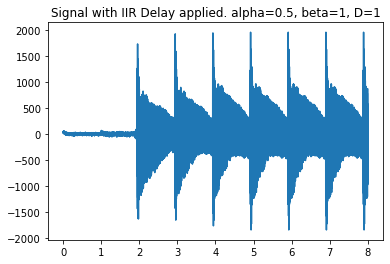

In [8]:
plot_iir_output(alpha=0.5, beta=1)

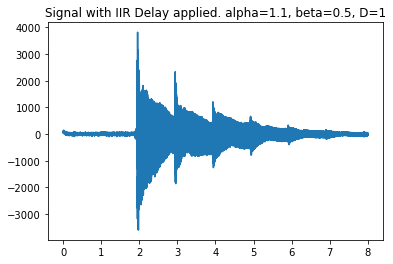

In [9]:
plot_iir_output(alpha=1.1, beta=0.5)

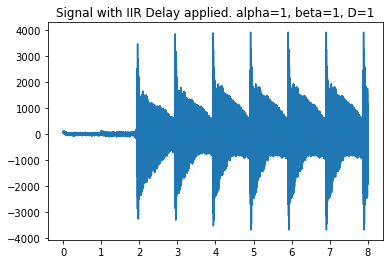

In [10]:
plot_iir_output(alpha=1, beta=1)

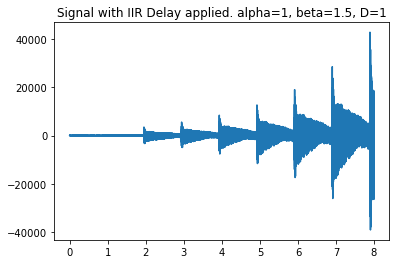

In [11]:
plot_iir_output(alpha=1, beta=1.5)

It is easy to notice that for $\beta \ge 1$ the output signal is becoming unstable as the energy keeps growing and over time goes towards infinity. The $\alpha$ parameter defines a scale of initial signal repetition. Having the signal with the filter applied it is possible to save it as a sound file and play it.

In [12]:
scipy.io.wavfile.write("string_delay.wav", sample_rate, sound_delay.astype(np.int16))
IPython.display.Audio("string_delay.wav")

Depending on the choice of the parameters the spectral analysis shows different outcomes of the filter. For $\alpha \le 1$ and $\beta \le 1$ the energy of the peaks is lower that the original one. If one of the parameters or both of them are greater than 1 the energy is growing. The peak frequencies do not change.

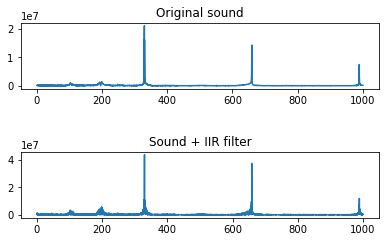

In [13]:
sound_delay = iir_delay(
    sound,
    alpha=0.5, 
    beta=1.1,
    delay=1,
    sample_rate=sample_rate,
    output_size=int(1.5*len(sound))
)

# Fourier transform of the signals.
sound_fft = scipy.fft.rfft(sound)
sound_delay_fft = scipy.fft.rfft(sound_delay)
# Compute corresponding frequencies.
xf = scipy.fft.rfftfreq(len(sound), 1/sample_rate)
xf_delay = scipy.fft.rfftfreq(len(sound_delay), 1/sample_rate)

# For the plot take only frequencies less equal 1000Hz.
mask = xf <= 1000
mask_delay = xf_delay <= 1000
xf = xf[mask]
xf_delay = xf_delay[mask_delay]
sound_fft = sound_fft[mask]
sound_delay_fft = sound_delay_fft[mask_delay]

# Plot spectrums of the signals.
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
ax1.plot(xf, np.abs(sound_fft))
ax1.set_title("Original sound")
ax2.plot(xf_delay, np.abs(sound_delay_fft))
ax2.set_title("Sound + IIR filter")
fig.tight_layout(pad=3.0)
plt.show()

## Conclusions
IIR delay filter allows to generate arbitrary lenght outputs. Depending on the parameters the implementation may become unstable thus one sould be mindful while choosing the parameters. In contrary FIR implementation is always stable as the formula is not recursive and signal is not going to be repeated. 